## A11535519 - Justin Laughlin
### MAE 290A: Homework 2 (10/19/17)
### Problem 1

In [1]:
# Import necessary packages & configure settings
import numpy as np
from scipy.sparse.linalg import gmres
from scipy import linalg
import matplotlib.pyplot as plt
import timeit
import time

%matplotlib inline
fs_med = 14 # medium font size for plots

Consider the linear system of equations $Ax=b$, where $A_{i,j} = |i-j|^{-1}$ if $i \neq j$ and $A_{ii}=10$, and $b_i=i$ for $i=1...100$. 

In [2]:
# Construct A using nested for loops
N = 100
A = np.ndarray([N,N], dtype=np.double)
for i in np.arange(N):
    for j in np.arange(N):
        if i == j:
            A[i,j] = 10
        else:
            A[i,j] = (np.abs((i+1)-(j+1)))**(-1)
# Construct b
b = np.arange(1,N+1)

In [3]:
print('Condition number of (A^T A): %e' % np.linalg.cond(np.dot(A.T,A)))

Condition number of (A^T A): 4.619571e+00


According to https://en.wikipedia.org/wiki/Condition_number a general rule of thumb is that the condition number $\rho(A) = 10^k$ means you may lose up to $k$ digits of accuracy. For residual minimization methods we are effectively solving the equation
$$A^T \cdot A \cdot x = A^T \cdot b$$
Which means our condition number is $\rho (A^T \cdot A) \sim \rho (A)^2$. Our condition number is $\sim 1$, which means $k \approx 0$ so our matrix is not ill-conditioned. We can safely invert using residual minimization methods without preconditioning.

Now let us solve the system using LU decomposition (which is not a residual minimization method!) and plot the solution. This will serve as somewhat of a baseline for the methods we use later.

In [4]:
# Forward substitution
# Solves Ly=f when L is lower diagonal
def fsub(L,f):
    # Initialize
    N = len(f)
    y = np.ndarray((N,), dtype=np.double)
    y[0] = f[0]/L[0,0]
    
    # Forward sub
    for j in np.arange(1,N):
        y[j] = (f[j] - np.dot(L[j,0:j],y[0:j]))/L[j,j]
    
    return y

# Backward substitution
# Solves Ux=y when U is upper diagonal
def bsub(U,y):
        # Initialize
    N = len(y)
    x = np.ndarray((N,), dtype=np.double)
    x[-1] = y[-1]/U[N-1,N-1]
    
    # Backward sub
    for j in np.arange(N-2,-1,-1):
        x[j] = (y[j] - np.dot(U[j,(j+1):],x[(j+1):]))/U[j,j]
    
    return x

# Solve Ax=f using LU decomposition
def LUsolve(A,f):
    # Perform LU decomposition. In scipy's implementation A = PLU
    P, L, U = linalg.lu(A)
    F = np.dot(P.T,f)
    y = fsub(L,F)
    x = bsub(U,y)
    
    return x

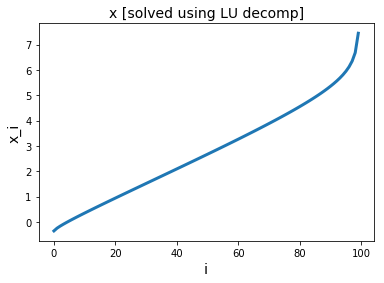

In [5]:
xlu = LUsolve(A,b)
plt.plot(np.arange(N),xlu,linewidth=3)
plt.xlabel('i',fontsize=fs_med)
plt.ylabel('x_i',fontsize=fs_med)
plt.title('x [solved using LU decomp]',fontsize=fs_med)

### Solve Ax=b using conjugate gradient method

Now, let us verify that we can solve this system using a conjugate gradient method.

There is a special case we can use when $A$ is a symmetric positive-definite matrix. We know that $A$ is symmetric because of its definition. We also suspect that $A$ is positive-definite because it is diagonally dominant. Showing that $A$ is positive-definite is equivalent to showing that all eigenvalues are positive; however solving for eigenvalues is typically a $\mathcal{O}(N^3)$ operation... Let's use the Gershgorin Circle Theorem (https://en.m.wikipedia.org/wiki/Gershgorin_circle_theorem) to show that all eigenvalues are positive (cheaply!) so that we may use the special case routine.

According to the Gershgorin Circle Theorem if $A$ is a complex $n \times n$ matrix, for $i \in {1,...,n}$, $R_i = \sum_{j, j\neq i}^N = |a_{ij}|$ is the sum of absolute values of the non-diagonal entries in the $i$th row. Let $D(a_{ii},R_i)$ be the closed disk centered at $a_{ii}$ with radius $R_i$; every eigenvalue of $A$ lies within at least one of the discs $D(a_{ii},R_i)$. 

Thus, if we can show that the sum of values along each row (excluding the entry on the diagonal) is less than the diagonal value, all eigenvalues must be positive!

In [6]:
pd_bool = True # positive-definite boolean
# loop over rows, check if R>D
for i in np.arange(N):
    R = A[i,np.arange(len(A))!=i].sum()
    D = A[i,i]
    if R>D:
        print('A is NOT positive-definite...sad days :(')
        pd_bool = False
# if for all rows D>R, A is positive-definite
if pd_bool == True:
    print('A is positive-definite! Nice!')

A is positive-definite! Nice!


Now let's code the conjugate gradient method:

In [7]:
# Conjugate gradient method to solve Ax=b
# x0: initial guess
# tol: tolerance
def conjGrad(A,b,x0,tol):
    rvec = [] # list of residues
    tvec = [] # time per iteration
    x = x0 # initial guess
    r = b-np.dot(A,x0) # initial residue
    p = r # initial search direction
    rnorm = np.linalg.norm(r)
    
    # main loop
    while rnorm >= tol:
        rvec.append(rnorm)
        alpha = np.dot(r,r)/(np.dot(np.dot(p,A),p))
        x = x + alpha*p
        rnew = r - alpha*np.dot(A,p)
        beta = np.dot(rnew,rnew)/np.dot(r,r)
        p = rnew + beta*p
        r = rnew
        
        # check tolerance
        rnorm = np.linalg.norm(r)     
        # check time
        tvec.append(time.time())
    rvec.append(rnorm)
    tvec.append(time.time())
    # convert to arrays
    tvec = np.asarray(tvec) - tvec[0]
    rvec = np.asarray(rvec)
    return x, rvec, tvec

Plot $x$ when solved using conjugate gradient and compare between different tolerances used. Compare with solution from LU decomposition as a baseline.

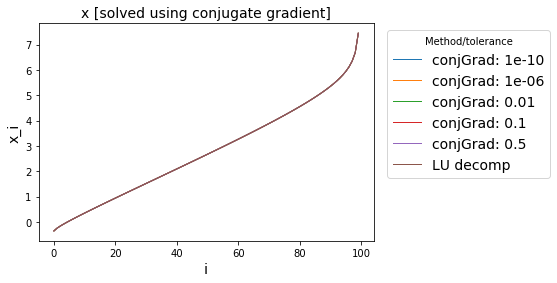

In [8]:
tolvec = np.array(([1e-10, 1e-06, 1e-02, 1e-01, 5e-01]))
for tol in tolvec:
    x,rvec,tvec = conjGrad(A,b,np.ones((N,)),tol)
    plt.plot(np.arange(N),x,linewidth=1,label='conjGrad: ' + str(tol))
plt.xlabel('i',fontsize=fs_med)
plt.ylabel('x_i',fontsize=fs_med)
plt.title('x [solved using conjugate gradient]',fontsize=fs_med)
plt.plot(np.arange(N),xlu,linewidth=1, label='LU decomp')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, fontsize=fs_med, title='Method/tolerance')

Great! It seems like the conjugate gradient method for all tolerances chosen provides a solution that is indistinguishable from LU decomposition when graphed. Let's now compare the computational time between tolerances for the conjugate gradient method and LU decomposition:

In [9]:
# This wrapper allows functions such as LUsolve() to be timed by timeit.timeit() so we can compare performance with Gauss Jordan
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

In [10]:
nrun = 2000 # number of times to run inversion algorithms for benchmarking
print("Time to solve using LUsolve() %d times:\t\t\t %.4f" % (nrun, timeit.timeit(wrapper(LUsolve,A,b), number = nrun)),"s")
for tol in tolvec:
    t = timeit.timeit(wrapper(conjGrad,A,b,np.ones((N,)),tol), number = nrun)
    print("Time to solve using conjGrad() %d times (tol=%.10f):\t %.4f" % (nrun,tol,t),"s")

Time to solve using LUsolve() 2000 times:			 1.7953 s
Time to solve using conjGrad() 2000 times (tol=0.0000000001):	 1.3556 s
Time to solve using conjGrad() 2000 times (tol=0.0000010000):	 0.6709 s
Time to solve using conjGrad() 2000 times (tol=0.0100000000):	 0.4245 s
Time to solve using conjGrad() 2000 times (tol=0.1000000000):	 0.5061 s
Time to solve using conjGrad() 2000 times (tol=0.5000000000):	 0.3907 s


As expected, in all cases conjGrad() solves the system faster than LUsolve()! For symmetric positive-definite matrices the conjugate gradient method is the fastest iterative solver.

### Solve Ax=b using GMRES

GMRES stands for Generalized Minimal RESidual. Let us define our function to minimize as the squared $L_2$ norm of the residual (other norms could be used as well):
$$f(x)=\frac12 ||r||^2 = \frac12 ||Ax-b||^2$$
The $\frac12$ term in front is simply to make the final expression for $f'(x)$ cleaner as we will see. We can expand $f(x)$ out by noting that the squared $L_2$ norm of a vector is simply the dot product of the vector by itself.
$$f(x) = \frac12 \left(Ax-b\right)^T \left(Ax-b\right) = \frac12 \left[x^T A^T A x - x^T A^T b - b^T A x + b^T b \right]$$

Now we will use two matrix calculus identities to find the gradient of $f(x)$:
$$\frac{\partial x^T A x}{\partial x} = (A+A^T) x, ~~~ \frac{a^T x}{\partial x} = \frac{\partial x^T a}{\partial x} = a$$

Take the derivative of $f(x)$ w.r.t. $x$:
$$f'(x) = \frac12 \left[(A^T A + A^T A) x - A^T b - A^T b \right] = A^T A x - A^T b$$

Setting the gradient to $0$ gives us an equation to solve for:
$$f'(x) = 0 \rightarrow A^T A x = A^T b$$

Notice that we now have a $A^T A$ term, which squares the significance of the condition number for $A$. This is why we checked at the beginning of this problem that $\rho(A)$ was sufficiently small to apply residual minimization techniques.

In [11]:
# hack solution to obtaining residual; bad to use a global definition. 
def giveres(r):
    global gmres_rvec
    if not ('gmres_rvec' in vars() or 'gmres_rvec' in globals()):
        gmres_rvec = []
        print('gmres_rvec initialized')
    gmres_rvec.append(r)
    t_gmres.append(time.time())
    #print('gmres(): residual = %e' % r)

Plot residual norm vs time (scaled using $\log_{10}$ due to the drastic difference in residual norms). Compare between GMRES and conjugate gradient for tolerances $1\mathrm{e}{-10}$ and $1\mathrm{e}{-6}$:

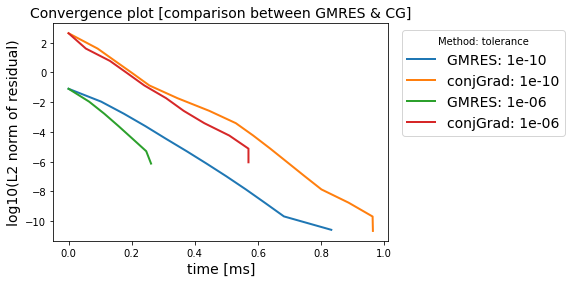

In [12]:
def convergencePlot(axesLabels):
    global gmres_rvec
    global t_gmres
    for tol in [1e-10, 1e-6]:
        gmres_rvec = []
        t_gmres = []
        x = gmres(A,b,tol=tol,callback=giveres)
        t_gmres = np.asarray(t_gmres) - t_gmres[0]
        plt.plot(t_gmres * 1e+3, np.log10(np.asarray(gmres_rvec)),linewidth=2,label='GMRES: ' + str(tol))
        xcg,rvec,tvec = conjGrad(A,b,np.ones((N,)),tol)
        plt.plot(tvec * 1e+3, np.log10(rvec), linewidth=2, label='conjGrad: ' + str(tol))
    if axesLabels == True:
        plt.xlabel('time [ms]',fontsize=fs_med)
        plt.ylabel('log10(L2 norm of residual)',fontsize=fs_med)
        plt.title('Convergence plot [comparison between GMRES & CG]',fontsize=fs_med)
        plt.legend(bbox_to_anchor=(1.02, 1), loc=2, fontsize=fs_med, title='Method: tolerance')

convergencePlot(True)

As expected, a lower tolerance corresponds to a quicker convergence. In general, conjugate gradient and GMRES seem to perform similarly in terms of speed (there is a large variance in runtimes, which I will demonstrate below by re-creating the same plot many times...)

Conjugate gradient only works on symmetric positive-definite matrices. GMRES is very useful because it is a general method which can be applied to non-symmetric and not positive-definite matrices.

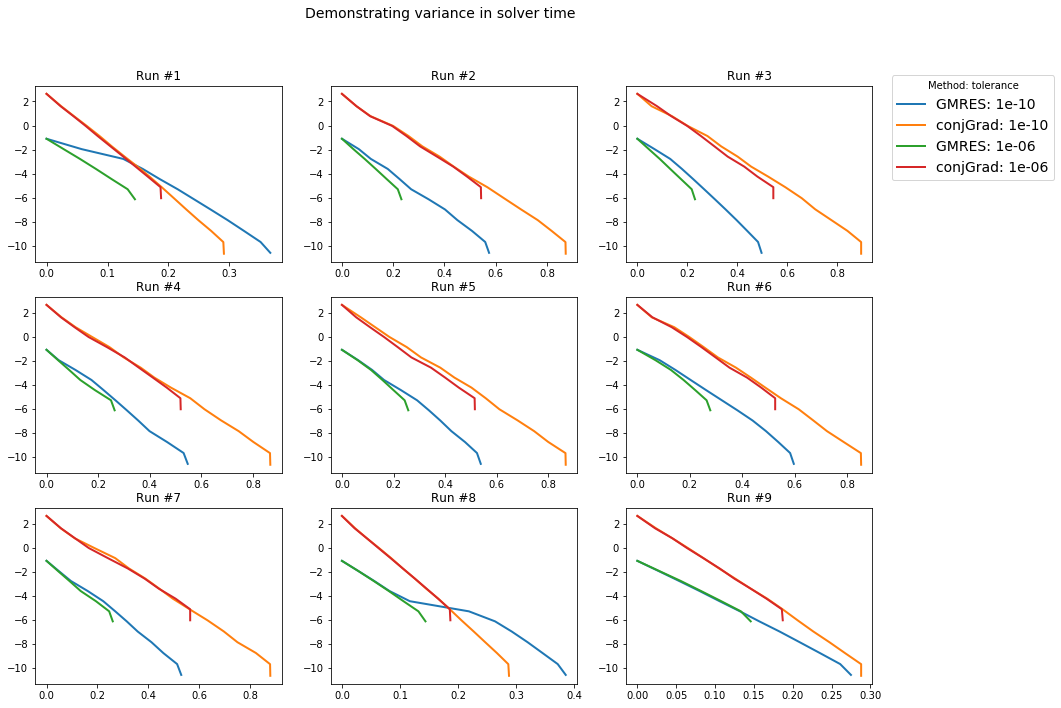

In [13]:
# Show the variance in runtimes
fig = plt.figure(figsize=(15, 11))
for j in np.arange(9):
    plt.subplot(3,3,j+1)
    convergencePlot(False)
    plt.title('Run #'+str(j+1))
plt.legend(bbox_to_anchor=(1.05, 3.5), loc=2, fontsize=fs_med, title='Method: tolerance')
plt.suptitle('Demonstrating variance in solver time',fontsize=fs_med)

In a theoretical computer with no machine error, the conjugate gradient method would converge ($||r||=0$) in at most $N$ operations. This means that it is a direct method and 

### Modifying A (to be non positive-definite)

If the matrix $A$ was modified such that $A_{i,j} = -10 \cdot |ij|^{-1}$ if $i=j$ and $A_{ii}=10$, instead of choosing the conjugate gradient method I would opt to use GMRES. Under this new condition we cannot guarantee $A$ is positive definite anymore as it is no longer diagonally dominant. The first version of $A$ had $N$ Gershgorin discs centered at $(10,0)$ and the largest had a radius of:

In [14]:
R = A[1,np.arange(len(A))!=1].sum()
print('Largest Gershgorin disc radius: %.3f' % R)

Largest Gershgorin disc radius: 6.167


All discs were in the right hand side of the complex plane, thus proving that all eigenvalues were positive. Under this modification of $A$ the largest disc radius would be $10$ times larger; a disc centered at $(10,0)$ with a radius of $61.67$ extends into the left hand plane, meaning negative eigenvalues are a possibility. GMRES provides a general method to solve matrices such as this one.

In [15]:
A2 = np.ndarray([N,N], dtype=np.double)
for i in np.arange(N):
    for j in np.arange(N):
        if i == j:
            A2[i,j] = 10
        else:
            A2[i,j] = -10*(np.abs((i+1)-(j+1)))**(-1)

In [16]:
np.linalg.cond(A2)**2

187632.60989463286

However, the squared condition number of this modified $A$ is a bit larger now; we may lose a little more than $5$ digits of accuracy according to our definition in the beginning ($\rho(A) = 10^k$ means you may lose up to $k$ digits of accuracy). Remember we must check the squared condition number as this is a residual minimization routine.

Since GMRES is fairly fast it would be nice if we could still use it while maintaining our accuracy. To solve this problem I would apply a preconditioner (Jacobi works fairly well, since $A$ is still diagonally dominant) to reduce the condition number as much as possible.